# Synthetic Trainer

In [4]:
import segmentation_models_pytorch as smp
import label_test_script
import albumentations as albu
import torch
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from segmentation_models_pytorch import utils
from sklearn.metrics import jaccard_score, f1_score
import tensorflow as tf
from torchmetrics.classification import F1Score, BinaryF1Score, MulticlassF1Score, JaccardIndex
from torchmetrics import Dice
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.utils import save_image
from PIL import Image
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter

/tmp/ipykernel_57395/2609561799.py:18: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


## Model Fleet

In [5]:
#Hyperparamters
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet' #pretrained weighting
ACTIVATION = "sigmoid"
num_classes = 12

#DEEPLABV3+

deeplab = smp.DeepLabV3Plus(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
)


#UNET
unet = smp.Unet(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    decoder_use_batchnorm = True,
)

fcn = smp.FPN(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
)

mobile = smp.Unet(
    in_channels=3,
    encoder_name="mobilenet_v2", 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    decoder_use_batchnorm = True,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

## Preprocessing Functions

In [6]:
SIZEX = 128
SIZEY = 128
rgb_vals = [ 0,1,2,3,4,5,6,7,8,9,10,11]


def to_tensor(x, **kwargs):
    x_t = x.transpose(2, 0, 1).astype('float32')
    #print("XTSHAPE", x_t.shape)
    return x_t


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),
        albu.Rotate((-18,18)),
        albu.PadIfNeeded(min_height=SIZEY, min_width=SIZEY, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.Perspective(p=0.5),
        albu.GaussNoise(p=0.2),
        albu.OneOf([albu.CLAHE(p=1),albu.RandomBrightness(p=1),albu.RandomGamma(p=1),],p=0.9,),
        albu.OneOf([albu.Sharpen(p=1),albu.Blur(blur_limit=3, p=1),],p=0.9,),albu.OneOf([albu.RandomContrast(p=1),albu.HueSaturationValue(p=1),],p=0.9,),
    ]

    return albu.Compose(train_transform)


def transformation_augs():
    train_transform = [
        #albu.HorizontalFlip(p=0.5),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(SIZEY, SIZEY)
    ]
    return albu.Compose(test_transform)

## Dataset

In [7]:
class MyDataSet(torch.utils.data.Dataset):

  def __init__(self, images_dir, masks_dir, coords_dir, preprocessing=None, classes=None,augmentation=None, mode="train"):
    super(MyDataSet, self).__init__()

    self.preprocessing = preprocessing
    self.augmentation = augmentation

    self.image_ids = os.listdir(images_dir)

    if mode == "train":
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids][200::]
      self.masks_fps = [os.path.join(masks_dir, mask_id.replace("_seg","")) for mask_id in self.image_ids][200::]
      self.coords_fps = [os.path.join(coords_dir, coords_id.replace("_seg.png", "_ldmks.txt")) for coords_id in self.image_ids][200::]
    else:
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids][:200]
      self.masks_fps = [os.path.join(masks_dir, mask_id.replace("_seg","")) for mask_id in self.image_ids][:200]
      self.coords_fps = [os.path.join(coords_dir, coords_id.replace("_seg.png", "_ldmks.txt")) for coords_id in self.image_ids][:200]


  def __len__(self):
    # a DataSet must know it size
    return len(self.images_fps)

  def __getitem__(self, i):

    image = cv2.imread(self.masks_fps[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.images_fps[i],0)

    # crop to center face
    smallest_x = 99999
    smallest_y = 99999
    biggest_x = -99999
    biggest_y = -99999
    with open(self.coords_fps[i], 'rb') as f:

      contents = str(f.read()).split("\\n")
      try:
        contents = [[int(float(single.replace("\\r", "").replace("'", "").replace("b", "").replace("\\x1a",""))) for single in pair.split(" ")] for pair in contents[1:-1]]
      except:
        print(contents)

      #contents = np.array(contents)
      for pair in contents:
        #plt.scatter((pair[0]), (pair[1]), color="red")

        if (pair[0]) < smallest_x:
          smallest_x = (pair[0])
        
        if (pair[0]) > biggest_x:
          biggest_x = (pair[0])

        if (pair[1]) < smallest_y:
          smallest_y = (pair[1])
        
        if (pair[1]) > biggest_y:
          biggest_y = (pair[1])


      crop_coords = (int(smallest_x), int(biggest_x), int(smallest_y), int(biggest_y))

      image = image[smallest_y: biggest_y, smallest_x:biggest_x]
      mask = mask[smallest_y: biggest_y, smallest_x:biggest_x]

    mask = cv2.resize(mask, (SIZEY, SIZEY))
    image = cv2.resize(image, (SIZEY, SIZEY))
    mask = np.expand_dims(mask,2)

    #convert mask to helen labels
    mask[mask == 0] = 100 #back
    mask[mask == 1] = 101 #skin
    mask[mask == 2] = 102 #nose
    mask[mask == 3] = 103 #right eye
    mask[mask == 4] = 104 #left eye
    mask[mask == 5] = 105 #right brow
    mask[mask == 6] = 106 # left brow
    mask[mask == 7] = 107 # right ear
    mask[mask == 8] = 108# left ear
    mask[mask == 9] = 109 # inner mouth
    mask[mask == 10] = 110# top lip
    mask[mask == 11] = 111# bottom lip
    mask[mask == 12] = 112# neck
    mask[mask == 13] = 113# hair
    mask[mask == 14] = 114# beard
    mask[mask == 15] = 115#clothing

    mask[mask == 100] = 0 #back
    mask[mask == 101] = 1 #skin
    mask[mask == 102] = 6 #nose
    mask[mask == 103] = 5 #right eye
    mask[mask == 104] = 4 #left eye
    mask[mask == 105] = 3 #right brow
    mask[mask == 106] = 2 # left brow
    mask[mask == 107] = 1 # right ear
    mask[mask == 108] = 1# left ear
    mask[mask == 109] = 8 # inner mouth
    mask[mask == 110] = 7# top lip
    mask[mask == 111] = 9# bottom lip
    mask[mask == 112] = 1# neck
    mask[mask == 113] = 10# hair
    mask[mask >10] = 11# ignore

    # smooth mask
    # mask = mask = scipy.ndimage.median_filter(mask, 5)

    # apply augmentations
    if self.augmentation:
        sample = self.augmentation(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
    
    # apply preprocessing
    if self.preprocessing:
        sample = self.preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']


    #onehot
    one_hot_Y = torch.nn.functional.one_hot(torch.tensor(mask).to(torch.int64), 12).permute(0,3,1,2).float()

    return (image, one_hot_Y.squeeze(0))


train_x_path = "/home/nathan/Documents/final_project/datasets/wood/images"
train_y_path = "/home/nathan/Documents/final_project/datasets/wood/labels"
train_coords_path = "/home/nathan/Documents/final_project/datasets/wood/landmarks"

train_ds = MyDataSet(train_y_path, train_x_path, train_coords_path, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_training_augmentation(), mode="train")
val_ds = MyDataSet(train_y_path, train_x_path, train_coords_path, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_validation_augmentation(), mode="val")
image_vis, gt_mask = train_ds[50]

/home/nathan/miniconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/nathan/miniconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


## Sanity Check

/tmp/ipykernel_57395/1066641470.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = label_test_script.colour_code_segmentation(label_test_script.reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


2000
0 : (3, 128, 128) torch.Size([12, 128, 128])


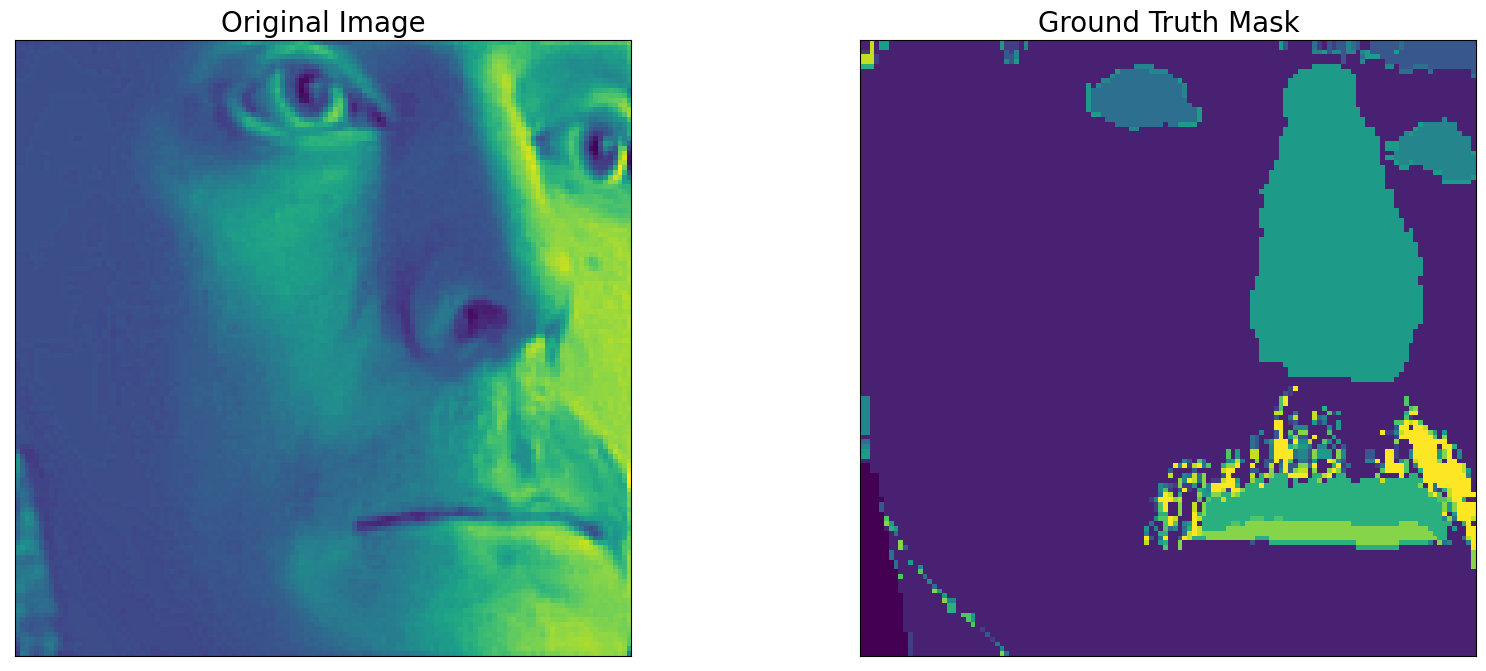

1 : (3, 128, 128) torch.Size([12, 128, 128])


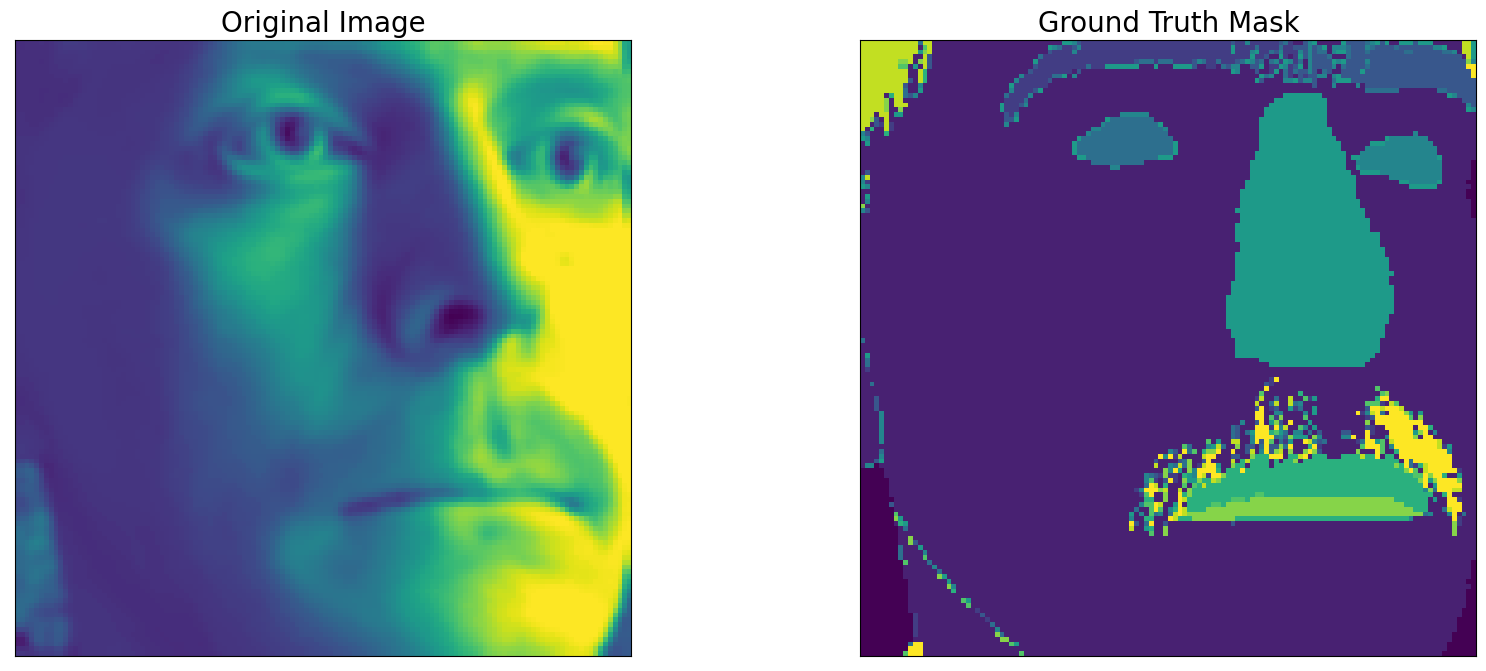

In [8]:
from matplotlib import pyplot as plt
from PIL import Image

print(len(train_ds))

for x in range(2):

  image_vis, gt_mask = train_ds[50]
  print(x, ":", image_vis.shape, gt_mask.shape)

  gt_mask = label_test_script.colour_code_segmentation(label_test_script.reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
  im = Image.fromarray(np.uint8(gt_mask))

  label_test_script.visualize(
      original_image = image_vis[0,::],
      ground_truth_mask = gt_mask
  )


### Data Loader

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=24, shuffle=True, num_workers=7)
valid_loader = DataLoader(val_ds, batch_size=24, shuffle=False, num_workers=7)

print(len(train_loader))

84


## Find Class Weights

In [10]:
weights_per_image = []
for x, pair in enumerate(train_ds):
  mask = pair[1]
  weights = []
  for layer in np.array(mask):
    count = np.sum(layer == 1)
    if count != 0:
      weights.append(count)
    else:
      weights.append(0)
  if x == 100:
    break

  weights_per_image.append(weights)

# average down collumns
wpi_numpy = np.array(weights_per_image)
wpi_avs = wpi_numpy.mean(axis=0)

normedWeights = [1 - (x / sum(wpi_avs)) for x in wpi_avs]
normedWeights = torch.FloatTensor(normedWeights)
normedWeights[-1] = 0.0 #ignore index
normedWeights

tensor([0.9455, 0.3398, 0.9911, 0.9894, 0.9902, 0.9895, 0.9099, 0.9785, 0.9864,
        0.9767, 0.9627, 0.0000])

In [11]:
TRAINING = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = smp.utils.losses.CrossEntropyLoss(weight=normedWeights)

# define evalusation metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

## Train Model

In [12]:
import matplotlib.pyplot as plt

def train_model(model, train_loader_given, valid_loader_given, saveas, epoch):

    #clear CUDA cache
    torch.cuda.empty_cache()

    # define optimizer
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

    # define learning rate scheduler
    #lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer)

    #define train ecpochs w/ our hyperparams
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

    #define train ecpochs w/ our hyperparams
    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )

    if TRAINING:

        best_iou_score = 0.0
        train_logs_list, valid_logs_list = [], []

        #Keep track of epoch BCE and IoU for graph plots
        epoch_count = []
        v_bce = []
        v_ious = []

        t_bce = []
        t_ious = []

        i = 0
        while i < epoch:
            i +=1 

            # Perform training & validation
            print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader_given)
            valid_logs = valid_epoch.run(valid_loader_given)
            #lr_scheduler.step()

            #log
            train_logs_list.append(train_logs)
            valid_logs_list.append(valid_logs)

            # Save model if a better val IoU score is obtained
            if best_iou_score < valid_logs['iou_score']:
                best_iou_score = valid_logs['iou_score']
                torch.save(model, saveas)
                print('Model saved!')

            v_ious.append(valid_logs['iou_score'])
            t_ious.append(train_logs['iou_score'])
            
            epoch_count.append(i)
        
            # Plot graph every 2 epochs
            if i % 2 ==0:
                plt.show()
                plt.plot(epoch_count,t_ious, label="Train IoU")
                plt.plot(epoch_count,v_ious, label="Valid IoU")
                plt.legend(loc="upper left")
                plt.xlabel("Epochs")
                plt.ylabel("IoU")
                plt.show()


### Function to view train model precitions

In [13]:
def average(lst):
    return sum(lst) / len(lst)

def view_predictions(model, ds, numm_classes ):

    ious = []
    f1s = []

    #predict
    for idx in range(10):

        image, gt_mask = ds[idx]
        image = image
        image_vis = image
        image_vis = np.transpose(image_vis,(1,2,0))
        x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
        pred_mask = model(x_tensor)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        pred_mask = label_test_script.colour_code_segmentation(label_test_script.reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
        gt_mask = label_test_script.colour_code_segmentation(label_test_script.reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
        
        #get IoU score
        #m = tf.keras.metrics.MeanIoU(num_classes=numm_classes)
        #m.update_state(gt_mask, pred_mask)
        #iou = m.result().numpy()
        #print("MEAN IoU:" , iou)
        #ious.append(iou)

        metric = MulticlassF1Score(num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        #metric = JaccardIndex(task="multiclass",num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        f1 = metric(torch.tensor(gt_mask), torch.tensor(pred_mask))
        if len(f1) == num_classes:
          f1[f1 <0.1] = np.nan
          #print(f1)
          f1s.append(np.array(f1))

        if idx:
          label_test_script.visualize(
              original_image = image[0,::],
              ground_truth_mask = gt_mask,
              predicted_mask = pred_mask,
          )

    
    fs1_numpy = np.array(f1s)
    av_f1s = np.nanmean(fs1_numpy, axis=0)
    #av_f1s = fs1_numpy.mean(axis=0)
    av_f1s_av = av_f1s.mean(axis=0)

    #print ("Dataset MIoU = ", average(ious))
    print ("Dataset F1 = ", av_f1s)
    print ("Dataset F1 av = ", av_f1s_av)

# Predict!

In [14]:
#train_model(unet, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/synth_100000/unet.pth", 50)
#train_model(fcn, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/synth_100000/fcn.pth", 50)
#train_model(mobile, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/synth_100000/mobile.pth", 50)
#train_model(deeplab, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/synth_100000/deeplab.pth", 50)